In [22]:
import itertools
from copy import deepcopy as copy
from scipy.linalg import fractional_matrix_power, block_diag
import networkx as nx
import cvxpy as cp
import matplotlib as mpl
import matplotlib.pyplot as plt 
import numpy as np
from operator import itemgetter
# from netgraph import InteractiveGraph # pip install netgraph

import scipy 
from numpy.linalg import matrix_rank as rank 
from Adversary import Problem, to_str, visualize, Adversary, hamming_dist as dist
from Solvers import type_mask, partial, ket, instance_mask, adv_solver
from ElementDistinctness import ED
from Examples import exact_k, threshold_k
from time import time
from itertools import product, permutations
mpl.rcParams["figure.dpi"] = 120
from multiprocessing.pool import ThreadPool as Pool

In [63]:
def get_oracles(funcs, oracle_getter, to_list=False):
    print('get_oracles', len(funcs))
    if to_list:
        return [oracle_getter(func) for func in funcs]
    return {func: oracle_getter(func) for func in funcs}

def cycle_oracle(func):
    return permutation_oracle(cycle_to_standard(func))

def get_phase_oracles(problem):
    oracles = {}
    # roots = nthRootsOfUnity(n)
    if isinstance(problem, Problem):
        instances = problem.instances
    n = len(instances[0])
    for instance in instances:
        oracle = np.zeros((n,n))
        for i in range(n):
            oracle[i, i] =-1 if instance[i] == 1 else 1
        oracles[instance] = oracle
        
    return oracles
def phase_oracle(func):
    oracle = np.zeros((len(func),len(func)))
    for i in range(len(func)):
        oracle[i,i] = func[i]
    return oracle 
def get_standard_oracles(problem):
    oracles = {}
    n = problem.n
    alpha_len = len(problem.alphabet)
    for instance in problem.instances:
        oracle = []
        for i in range(n):
            curr_oracle = np.zeros((alpha_len, alpha_len))
            for a in problem.alphabet:
                curr_oracle[a, (instance[i] + a) % alpha_len] = 1
            # print(curr_oracle)
            oracle.append(copy(curr_oracle))
        oracles[instance] = block_diag(*oracle)
        # print(oracles[instance])
    return oracles
def standard_oracle(func, alpha_len=None):
    n = len(func)
    if alpha_len is None:
        alpha_len = n
    oracle = []
    for i in range(n):
        curr_oracle = np.zeros((alpha_len, alpha_len))
        for a in range(alpha_len):
            curr_oracle[a, (func[i] + a) % alpha_len] = 1
            # print(curr_oracle)
        oracle.append(copy(curr_oracle))
    return block_diag(*oracle)

def get_oracle_diffs(oracles, prod=True, mat=False, keys=None, threads=8):
    n=oracles[0].shape[0]
    if np.linalg.norm(np.imag(np.block([oracles]))) == 0:
        oracle_diffs = np.zeros([n * len(oracles)]*2)
    else:
        oracle_diffs = np.zeros([n * len(oracles)]*2, dtype=complex)
    # print("keys", keys)
    I = np.eye(oracles[0].shape[0])
    if keys is None:
        keys = list(range(len(oracles)))
    # keys.sort()
    keys = list(range(len(oracles)))
    def diff_map(v):
        v1, v2 = v
        return I - oracles[v1].T @ oracles[v2]
    # counter = 0
    pool = Pool(threads)
    for v1 in keys:
        if not v1 % 100:
            print(v1/len(oracles))
        oracle_diffs[v1*n:(v1+1)*n] = np.hstack(pool.map(diff_map, list(product([v1], keys))))
    return oracle_diffs
def phase_oracle_diffs(perms):
    # phase_mats = [permutation_oracle(perm) for perm in perms]
    diffs = [[_ for _ in range(len(perms))] for _2 in range(len(perms))]
    # print('diffs', diffs)
    n = len(perms[0])
    for i in range(len(perms)):
        for j in range(len(perms)):
            diff = np.zeros((len(perms[i]), len(perms[i])))
            for r in range(n):
                # for c in range(n):
                if perms[i][r] != perms[j][r]:
                    diff[r,r] = 1
            # print('ij', i, j)
            diffs[i][j] = diff
    return diffs
    
def permutation_oracle(perm, nonstandard=False):
    n = len(perm)
    
    oracle = np.zeros((n, n))
    for i in range(n):
        oracle[perm[i], i] = 1
    return oracle

def get_permutation_oracles(instances):
    # assuming instances are all lists representing permutations
    oracles = {}
    n = len(instances[0])
    print(n)
    # assert tuple(range(n)) == problem.alphabet
    for instance in instances:
        oracle = np.zeros((n, n))
        for i in range(n):
            oracle[i, instance[i]] = 1
        oracles[instance] = oracle
        # assert oracle@oracle.T - np.eye(n)
    return oracles

def preimage_even_odd(n):
    perms = itertools.permutations(range(n))
    no_instances = []
    yes_instances = []
    for perm in get_cycles(n,n):
        # print(to_str(perm))
        if perm.index(0) >= n//2:
            yes_instances.append(perm)
        else:
            no_instances.append(perm)
    return Problem(no_instances, yes_instances)

In [64]:
# def get_cycles(n):
#     k=n
#     perm = tuple(range(n))
#     yes_instances = set()
#     for cycle_points in itertools.permutations(perm, k):
#         curr_cycle = list(perm)
#         for i in range(k-1):
#             curr_cycle[cycle_points[i]] = cycle_points[i+1]
#         curr_cycle[cycle_points[-1]] = cycle_points[0]
#         yes_instances.add(tuple(curr_cycle))
#     return list(yes_instances)
def num_fixed_points(perm):
    curr_sum = 0
    for i in range(len(perm)):
        if perm[i] == i:
            curr_sum += 1
    return curr_sum

def permutation_thresh(n, k):
    # perm = nkp.array(range(n))
    no_instances = set()
    yes_instances = set()
    for perm in itertools.permutations(tuple(range(n))):
        num_fixed = num_fixed_points(perm)
        if num_fixed == k:
            no_instances.add(perm)
        elif num_fixed == k + 1:
            yes_instances.add(perm)
    return Problem(list(no_instances), list(yes_instances))
def equality(n):
    perms = list(itertools.permutations(list(range(n))))
    no_instances = []
    yes_instances = [tuple(perm + tuple(p + n for p in perm)) for perm in perms]
    for perm1, perm2 in itertools.combinations_with_replacement(perms, 2):
        instance = tuple(perm1+ tuple(p + n for p in perm2))
        if dist(perm1, perm2) == 2:
            no_instances.append(instance)
    return Problem(no_instances, yes_instances)


def fixed_points(n, k):
    no_instances = []
    yes_instances = []
    for perm in itertools.permutations(range(n)):
        fp = num_fixed_points(perm)
        if fp == k:
            no_instances.append(perm)
        elif fp == k+1:
            yes_instances.append(perm)
    return Problem(no_instances, yes_instances)
        
def cycle0(n, k):
    no_instances = [cycle for cycle in get_cycles(n, k) if cycle[0] != 0]
    yes_instances = [cycle for cycle in get_cycles(n, k+1) if cycle[0] != 0]
    return Problem(no_instances, yes_instances)
def cycle(n, k, k2=None):
    if k2 is None:
        k2 = k+1
    no_instances = get_cycles(n,k)
    yes_instances = get_cycles(n, k2)
    return Problem(no_instances, yes_instances)

def preimage(n, k):
    # perms = list(itertools.permutations(range(n)))
    no_instances = []
    yes_instances = []
    for perm in get_cycles(n, k):
        preimage0 = perm.index(0)
        # print(preimage0, perm)
        if preimage0 % 2:
            yes_instances.append(perm)
        else:
            no_instances.append(perm)
    # print(no_instances)
    # print(yes_instances)
    return Problem(no_instances, yes_instances)
def get_all_cycles(perm):
    cycles =[]
    points_in_cycles = set()
    for i in range(n):
        if i not in points_in_cycles and perm[i] != i:
            cycle = [i]
            j = perm[i]
            points_in_cycles.add(j)
            while j not in cycle:
                cycle.append(j)
                j = perm[j]
                points_in_cycles.add(j)
            cycles.append(tuple(cycle))
    return cycles

def num_cycles(perm):
    return len(get_all_cycles(perm))
        
def transpose_thresh(n, k):
    perms = itertools.permutations(range(n))
    no_instances = []
    yes_instances = []
    for perm in perms:
        cycles = get_all_cycles(perm)
        cycle_lengths = set(len(cycle)  for cycle in cycles)
        if cycle_lengths == set([2]):
            if len(cycles) == k:
                no_instances.append(perm)
            elif len(cycles) == k+1:
                yes_instances.append(perm)
    return Problem(no_instances, yes_instances)

def transpose(n, easy=False):
    perm = tuple(range(n))
    no_instances = []
    if easy:
        for i in range(n//2):
            instance = list(perm)
            instance[2*i] = 2*i + 1
            instance[2*i+1] = 2*i
            no_instances.append(tuple(instance))
    else:
        for i,j in itertools.combinations(perm, 2):
            # print(i,j)
            instance = list(perm)
            instance[i] = j
            instance[j] = i
            no_instances.append(tuple(instance))
    return Problem([perm], list(no_instances))

def relative_hadamard_norm_min(mat, relative, D1_len):
    mat_len = mat.shape[0]
    mat_size = mat_len
    D1 = list(range(D1_len))
    D2 = list(range(D1_len, mat_size))
    relative_shape = relative[0][0].shape
    t = cp.Variable(nonneg=True)
    X = [[cp.Variable(relative_shape) for _ in range(mat_len)] for _ in range(mat_len)]
    for x in D1:
        for y in D2:
            X[x][y] = cp.Variable(relative_shape)
    constraints = [cp.bmat(X) >> 0]
    constraints += [
        mat[x][y] == cp.trace(X[x][y].T @ relative[x][y]) 
        for x in range(mat_size) for y in range(mat_size)
    ]
    constraints += [
        t >= cp.trace(X[z][z]) for z in range(mat_size)
    ]
    
    opt_prob = cp.Problem(cp.Minimize(t), constraints)
    opt_prob.solve(verbose=True) 
    for x in range(mat_size):
        for y in range(mat_size):
            X[x][y] = X[x][y].value
    return X
    
def relative_hadamard_norm_max(mat, relative_mat, D_len, solver="MOSEK", uni=True, threads=8, extra_constraints=None):
    print('shapes', )
    relative_shape = [0,0]
    relative_shape[0] = relative_mat.shape[0] // mat.shape[0]
    relative_shape[1] = relative_mat.shape[1] // mat.shape[1]
    relative_shape = tuple(relative_shape)
    
    # print(D1_len, len(D2), relative.shape)
    # relative_mat = np.block(relative)

    print(relative_mat.shape)
    Y = cp.Variable((D_len, D_len), hermitian=True)
    Lambda = cp.Variable((D_len, D_len), hermitian=True)
    print(relative_shape)
    Lambda_relative = cp.kron(Lambda, np.ones(relative_shape))
    Lambda_relative = cp.multiply(Lambda_relative, relative_mat)
    diag = cp.kron(cp.diag(cp.diag(Y)), np.eye(relative_shape[0]))
    if not uni:
        Lambda_relative = cp.bmat([
            [np.zeros(Lambda_relative.shape), Lambda_relative],
            [Lambda_relative.H, np.zeros(Lambda_relative.shape)] 
        ])
        diag = cp.kron(diag, np.eye(2))
    # print(W.shape, diag.shape)
    # W = Lambda_relative - diag
    # print(W)
    constraints = [cp.trace(Y) == 1, Lambda_relative << diag]
    if extra_constraints is not None:
        constraints = constraints + [eval(constraint) for constraint in extra_constraints]
        
    opt_prob = cp.Problem(cp.Maximize(2 * cp.sum(cp.real(cp.multiply(Lambda.T, mat)))), constraints)
    opt_prob.solve(verbose=True, solver=solver, mosek_params= {"MSK_IPAR_NUM_THREADS": threads})
    # opt_prob.solve(verbose=True, solver="SCS")
                # eps_rel=1e-4,
                # eps_infeas=1e-7)
    return Lambda.value, Y.value, Lambda_relative.value


def to_adversary_mat(Lambda, mu):
    G = np.zeros(Lambda.shape)
    for x in range(Lambda.shape[0]):
        for y in range(Lambda.shape[1]):
            G[x,y] = Lambda[x,y]/np.sqrt(mu[x] * mu[ y])
            
    return G

In [65]:
def search_perm_sorter(perms):
    n = len(perms[0])
    print('n', n)
    perm_types = {i:[] for i in range(n)}
    for perm in perms:
        perm_types[perm.index(0)].append( perm)
    for t in perm_types:
        perm_types[t].sort()
    perm_assignment = {}
    curr_perm = 0
    for i, permsi in perm_types.items():
        permsi = list(permsi)
        for perm in permsi:
            perm_assignment[perm] = curr_perm
            curr_perm += 1
    # print(perm_assignment)
    return perm_assignment, perm_types
# cycle_to_st
def search_mask(funcs, assignment=None, marker=0):
    size = len(funcs)
    if assignment is None:
        assignment = search_perm_sorter(funcs)
    if assignment == 'same':
        assignment = {funcs[i]: i for i in range(len(funcs))}
    # print(size)
    mask = np.zeros((size, size))
    for f in funcs:
        f0 = f.index(marker)
        for g in funcs:
            g0 = g.index(marker)
            if f0 != g0:
                mask[assignment[f], assignment[g]] = 1
    return mask
def index_or(n):
    funcs = list(set(itertools.permutations([1] + [0] * (n-1))))
    funcs.sort()
    print(funcs)
    size = len(funcs)
    return funcs, search_mask(funcs, assignment='same', marker=1)
# print(index_or(n))
def cycle_to_standard(cycle, nonstandard=True):
    n = len(cycle)
    if nonstandard:
        elements = list(cycle)
        elements.sort()
        cycle = tuple(elements.index(cycle[i]) for i in range(n))
    perm = list(range(n))
    for i in range(n):
        perm[cycle[i]] = cycle[(i+1)%n]
    return perm
def get_shift(perm, k, l):
    # take p_{k+1}->...->p_l and insert and put it at the end
    cycle_perm = get_all_cycles(perm)[0]
    # print('get_all cycles', perm, cycle_perm)
    shifted_cycle = cycle_perm[:k+1] + cycle_perm[l+1:] + cycle_perm[k+1: l+1]
    # print('shift', cycle_perm, shifted_cycle)
    # print(k, l, cycle_perm, shifted_cycle)
    # print(k,l, get_all_cycles(cyclecycle_perm)[0], get_all_cycles(shifted_cycle))
    # print(shifted_cycle)
    # print(cycle_to_standard(shifted_cycle)
    assert len(perm) == len(shifted_cycle) 
    return tuple(cycle_to_standard(shifted_cycle))

def get_all_k_shift(perm, k):
    n = len(perm)
    # print('shift', list({get_shift(perm, k, j) for j in range(k+1, n-1)}))
    return list({get_shift(perm, k, j) for j in range(k+1, n-1)})

def get_n_cycles(n):
    cycles = itertools.permutations(range(n))
    perms = set()
    for cycle in cycles:
        perm = list(range(n))
        for i in range(n):
            perm[cycle[i]] = cycle[(i+1)%n]
        perms.add(tuple(perm))
    return list(perms)

def lv_search_mat(n, shift=None):
    cycles = get_n_cycles(n)
    # print(cycles)
    search_perm_sorter(cycles)
    assignment, perm_types = search_perm_sorter(cycles)
    one_pairs = dict()
    for cycle in cycles:
        # print(cycle)
        # print(get_all_k_shift(cycle))
        one_pairs[cycle] = []
        if shift is None:
            for k in range(1, n-1):
                one_pairs[cycle] = one_pairs[cycle] + get_all_k_shift(cycle, k)
        else: 
            one_pairs[cycle] = get_all_k_shift(cycle, shift)
    # print('pairs', one_pairs)
    mat = np.zeros((len(cycles), len(cycles)))
    for cycle in cycles:
        for pair in one_pairs[cycle]:
            # print(cycles, pair)
            mat[assignment[cycle], assignment[pair]] = 1
    return mat
def get_special_cycles(n, m, decision=False):
    perm_items = list(product(range(n), range(m)))
    # print(perm_items)
    index_cycles = get_cycles(n*m)
    # print('got all cycles')
    # print(index_cycles)
    preimage_dict = {str(y):[] for y in range(1, n)}
    cycles = [tuple(to_str(perm_items[index_cycle[i]]) for i in range(n*m)) for index_cycle in index_cycles]
    special_cycles = []
    # print(cycles)
    bad_cycles = []
    for cycle in cycles:
        if cycle[-1][1]=='0':
            # print(cycle)
            special_cycles.append(cycle)
            preimage_dict[cycle[-1][0]].append(cycle)
        else:
            bad_cycles.append(cycle)
    if decision:
        assignment_special = cycle_sort(special_cycles)
        assignment_bad = cycle_sort(bad_cycles)
        all_cycles = special_cycles + bad_cycles
        assignment = {all_cycles[i]: i for i in range(len(all_cycles))}
        preimage_dict = {0: special_cycles, 1: bad_cycles}
        return all_cycles, assignment, preimage_dict
    
    assignment = cycle_sort(special_cycles)
    for v, i in assignment.items():
        special_cycles[i] = v
    
    # print('returning special cycles')
    return special_cycles, assignment, preimage_dict
# phase_oracle_diffs([cycle_to_standard(cycle) for cycle in perms
def get_cycles(n):
    cycles = []
    for perm in permutations(range(1, n)):
        cycles.append((0,) + perm)
    return cycles
def to_str(l):
    return ''.join(str(a) for a in l)
def list_to_str(L):
    return [to_str(l) for l in L] 

def cycle_sort(cycles):
    cycles.sort(key=itemgetter(-1))
    return {cycles[i]: i for i in range(len(cycles))}

def shift(cycle, l, k):
    cycle2 = cycle[:k+1] + cycle[l+1:] + cycle[k+1:l+1]
    return cycle2

def mask_maker(assignment, cases):
    mat = np.zeros((len(assignment), len(assignment)))
    for case1 in cases:
        for case2 in cases:
            if case1 != case2:
                for perm1 in cases[case1]:
                    for perm2 in cases[case2]:
                        # print('cases', case1, case2)
                        # print('perms',perm1, perm2)
                        mat[assignment[perm1], assignment[perm2]] = 1
    return mat

def function_erasure_mask(funcs, target=0):
    n = len(funcs[0])
    start_vects = []
    end_vects = []
    for func in funcs:
        inv = func.index(target)
        end_vect = np.zeros((n, n)) 
        end_vect[:, 0] = 1
        end_vect[inv,0] = 0
        start_vect = np.zeros((n,n))
        for i in range(n):
            if i != inv:
                start_vect[i, func[i]] = 1
        start_vects.append(start_vect)
        end_vects.append(end_vect)
    mask = np.zeros((len(funcs), len(funcs)))
    for i in range(len(funcs)):
        # print(start_vects[i])
        for j in range(len(funcs)):
            # print(end_vects[i])
            mask[i,j] = np.trace(start_vects[i].T@start_vects[j]) - np.trace(end_vects[i].T@end_vects[j])
    return mask
def nthRootsOfUnity2(n): # constant space, serial
    from cmath import exp, pi
    c = 2j * pi / n
    return [exp(k * c) for k in range(n)]
def real_phase_oracle(func):
    n = len(func)
    roots = nthRootsOfUnity2(n)
    oracle = np.zeros((n,n), dtype=complex)
    for i in range(n):
        oracle[i,i] = roots[i]
    return oracle

n 3
get_oracles 2
get_oracles 2
0.0
get_oracles 2
0.0
done with oracles
diff start
0.0
diff end
mat
mat_end


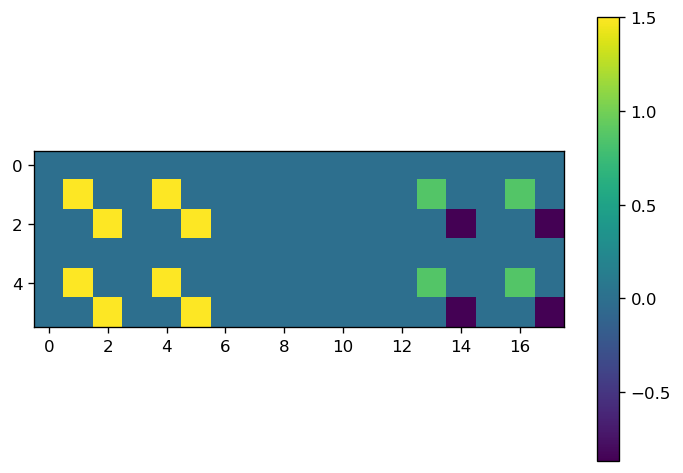

[[0. +0.j        0. +0.j        0. +0.j        0. +0.j
  0. +0.j        0. +0.j       ]
 [0. +0.j        1.5+0.8660254j 0. +0.j        0. +0.j
  1.5+0.8660254j 0. +0.j       ]
 [0. +0.j        0. +0.j        1.5-0.8660254j 0. +0.j
  0. +0.j        1.5-0.8660254j]
 [0. +0.j        0. +0.j        0. +0.j        0. +0.j
  0. +0.j        0. +0.j       ]
 [0. +0.j        1.5+0.8660254j 0. +0.j        0. +0.j
  1.5+0.8660254j 0. +0.j       ]
 [0. +0.j        0. +0.j        1.5-0.8660254j 0. +0.j
  0. +0.j        1.5-0.8660254j]]


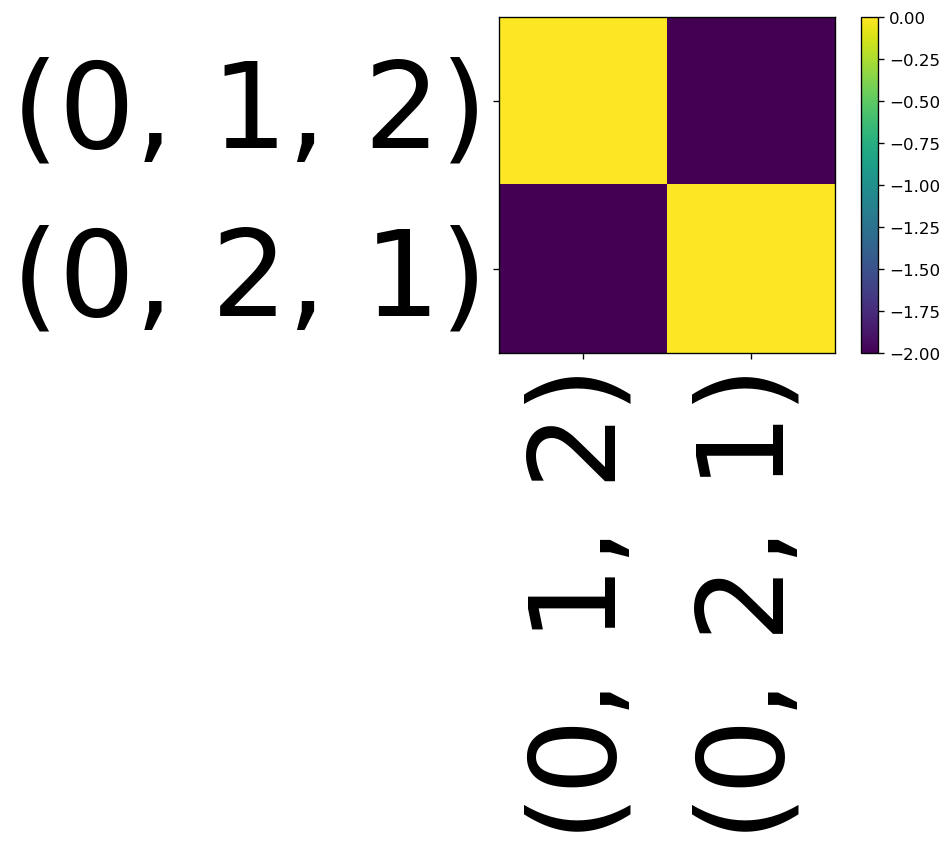

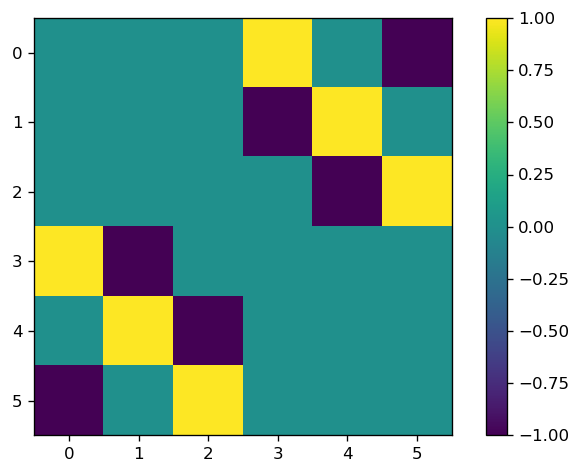

shapes
(6, 6)
(3, 3)
                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Aug 03 05:55:09 PM: Your problem has 8 variables, 37 constraints, and 0 parameters.
(CVXPY) Aug 03 05:55:09 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 03 05:55:09 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 03 05:55:09 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Aug 03 05:55:09 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 03 05:55:09 PM: Compiling problem (targ

TypeError: Image data of dtype object cannot be converted to float

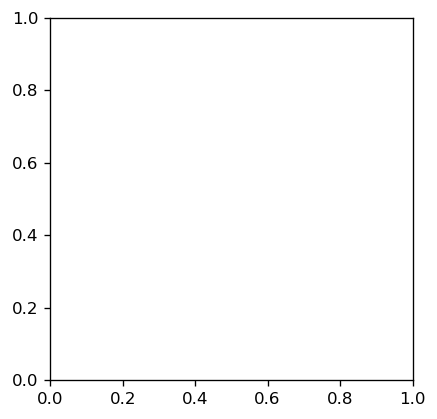

In [66]:
n = 3
m = 1

perms = get_cycles(n)
# standard_perms = [cycle_to_standard(cycle) for cycle in perms]
keys, perm_types = search_perm_sorter(perms)
inv_keys = {v:key for key, v in keys.items()}
sorted_perms = [inv_keys[i] for i in range(len(keys))]

standard_perms = [cycle_to_standard(perm) for perm in perms]
oracles = get_oracles(perms, cycle_oracle, to_list=True)
standard_oracles = get_oracles(standard_perms, standard_oracle, to_list=True)
standard_diffs = get_oracle_diffs(standard_oracles, mat=True, keys=keys)

phase_oracles = get_oracles(standard_perms, real_phase_oracle, to_list=True)
phase_diffs = get_oracle_diffs(phase_oracles, phase_oracle_diffs)

print('done with oracles')
print('diff start')
oracle_diffs = get_oracle_diffs(oracles, prod=True, mat=True, keys=keys)
print('diff end')

# oracle_diffs = np.block(oracle_diffs_list)
print('mat')
# mat = function_erasure_mask(perms)
# print(preimage_dict)
mat = function_erasure_mask(perms)
print('mat_end')
visualize(phase_diffs, complex=True)
print(phase_diffs)
visualize(mat, (perms, perms))
visualize(oracle_diffs)
Lambda, Y, W = relative_hadamard_norm_max(mat, phase_diffs, len(perms), uni=True)
visualize(np.real(Lambda), (perms, perms), to_string=True)
visualize(np.real(W))
visualize(np.real(Y))
# visualize(np.real(Lambda*mat))
# print(np.max(np.abs(np.imag(Lambda))))

                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Aug 03 05:45:51 PM: Your problem has 16 variables, 84 constraints, and 0 parameters.
(CVXPY) Aug 03 05:45:51 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 03 05:45:51 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 03 05:45:51 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Aug 03 05:45:51 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 03 05:45:51 PM: Compiling problem (target solver=MOSEK).
(C

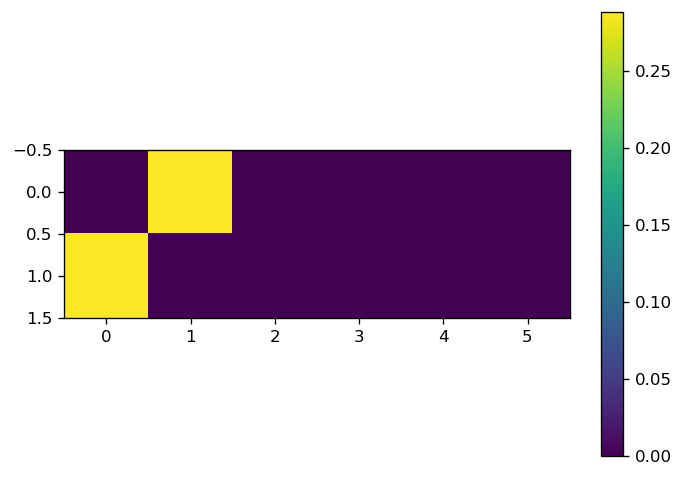

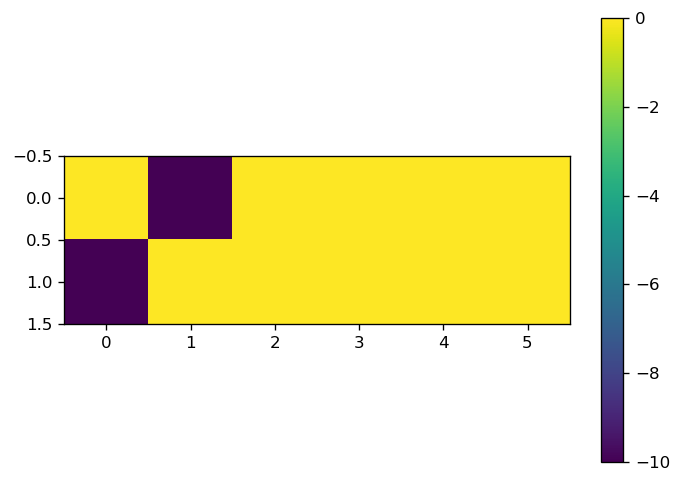

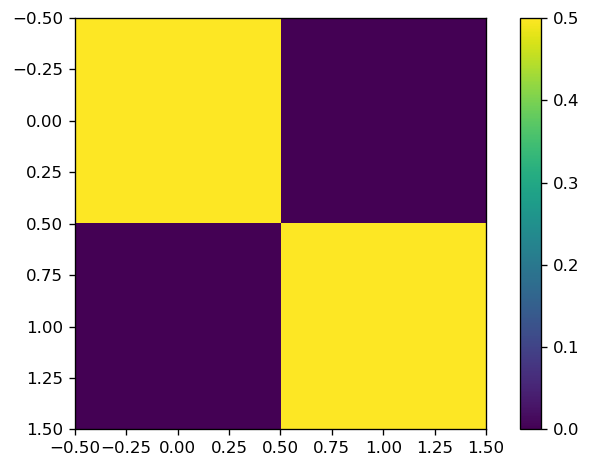

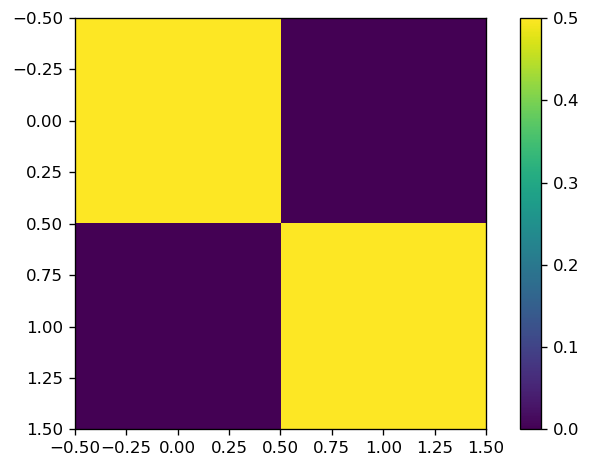

In [ ]:
def max_relative_increase(mat1, mat2, block_size):
    # M is a matrix that applies weights to the blocks of mat
    # Goal: find M which maximizes lmax(M*mat1)/lmax(M*mat2)
    # in other words, maximize lmax(M*mat1) given lmax(M*mat2)<=1
    # mat1 and mat2 have the same shape
    size = mat1.shape[0] // block_size
    Y1 = cp.Variable((size, size), PSD=True)
    Y2 = cp.Variable((size, size), PSD=True)
    M1 = cp.Variable((size,size), hermitian=True)
    M2 = cp.Variable((size,size), hermitian=True)
    M_big1 = cp.kron(M1, np.ones((block_size, block_size)))
    M_big2 = cp.kron(M2, np.ones((block_size, block_size)))
    # print(M_big.shape, mat2.shape)
    # M_big = cp.multiply(M_big, mat2)
    diag1 = cp.kron(cp.diag(cp.diag(Y1)), np.eye(block_size))
    diag2 = cp.kron(cp.diag(cp.diag(Y2)), np.eye(block_size))
    # print(W.shape, diag.shape)
    # W = Lambda_relative - diag
    # print(W)
    constraints = [cp.trace(Y1) == 1, cp.trace(Y2)==1, cp.multiply(M_big1, mat1) << diag1, cp.multiply(M_big1, mat2) << diag2]
    constraints += [cp.norm(M1, 2) <= 10, cp.norm(M2, 2)<=10]
    constraints += [cp.multiply(M1, np.eye(M1.shape[0])) == 0, cp.multiply(M2, np.eye(M2.shape[0]))==0]
    opt_prob = cp.Problem(cp.Maximize(cp.real(cp.sum(M1-M2))), constraints)
    opt_prob.solve(verbose=True, solver="MOSEK", mosek_params= {"MSK_IPAR_NUM_THREADS": 8})
    # opt_prob.solve(verbose=True, solver="SCS")
                # eps_rel=1e-4,
                # eps_infeas=1e-7)
        
    return M1.value, M2.value, Y1.value, Y2.value

phase_diffs = np.block(phase_oracle_diffs(perms))
perm_diffs = oracle_diffs
M1, M2, Y1,Y2 = max_relative_increase(perm_diffs, phase_diffs, n)
# print(M_big)
visualize(M1, complex=True)
visualize(M2, complex=True)
visualize(Y1)
visualize(Y2)

(6, 6)
[-0.0044032, 0.0, 0.0055691, 0.0454741, 0.1762842]
big 0123 0231 3
big 0123 0312 3
small 0123 0321 4
big 0132 0213 3
small 0132 0231 4
big 0132 0321 3
big 0213 0132 3
small 0213 0312 4
big 0213 0321 3
big 0231 0123 3
small 0231 0132 4
big 0231 0312 3
big 0312 0123 3
small 0312 0213 4
big 0312 0231 3
small 0321 0123 4
big 0321 0132 3
big 0321 0213 3
valmat {0.0, -0.058761395451928045, -0.058761395452304827, -0.05876139545209484, 0.002201595008904576, -0.05876139545187358, -0.058761395451449906, -0.058761395451530356, 0.0022015950087260995, 0.0022015950086886446}


C:\Users\blake\AppData\Local\Temp/ipykernel_1296/4141697953.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  val_mat_max[i,j] = Lambda[i,j]
C:\Users\blake\AppData\Local\Temp/ipykernel_1296/4141697953.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  val_mat_min[i,j] = Lambda[i,j]


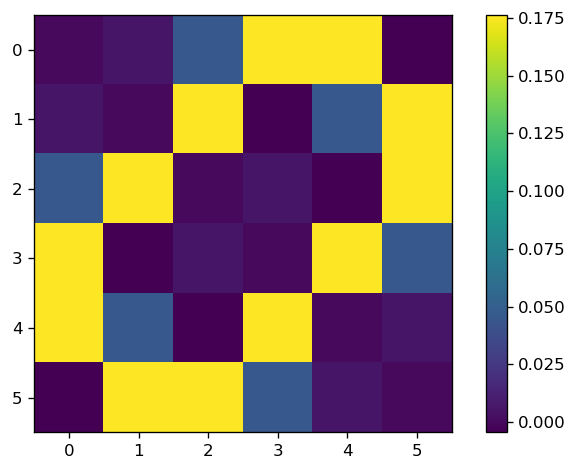

min


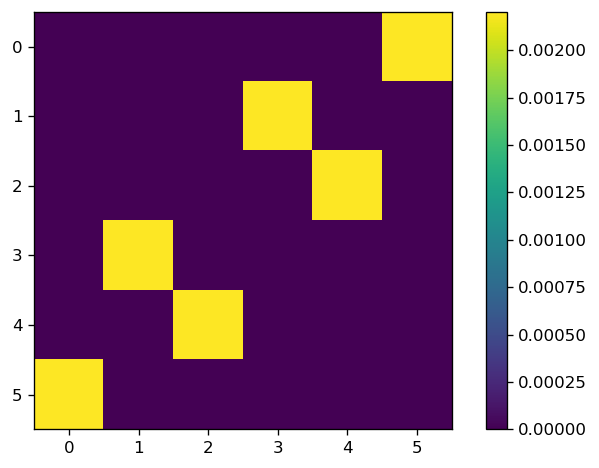

max


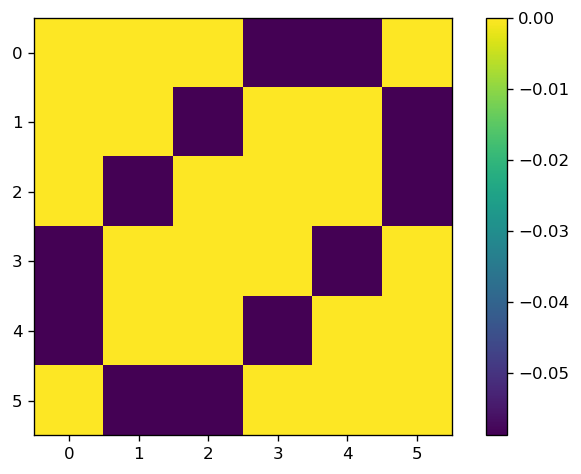

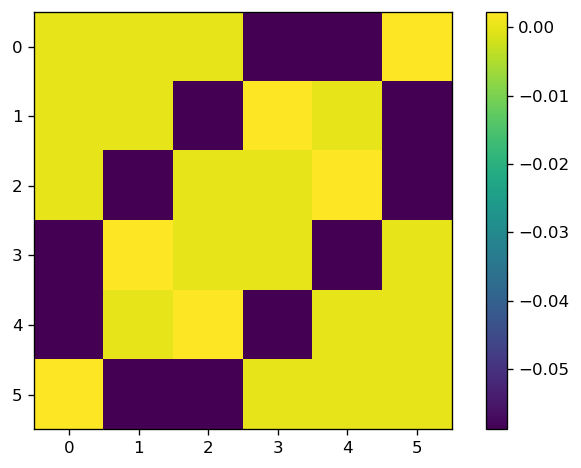

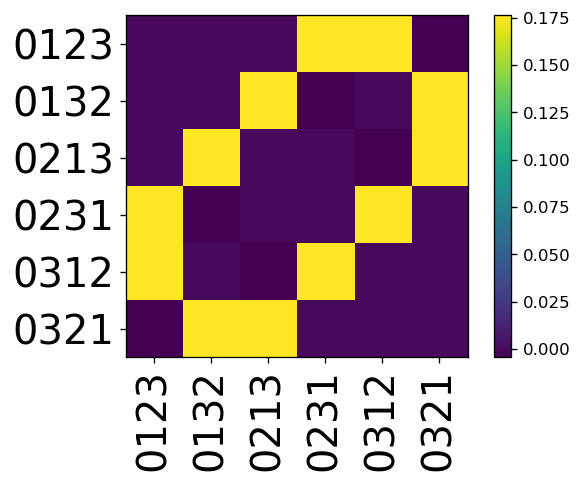

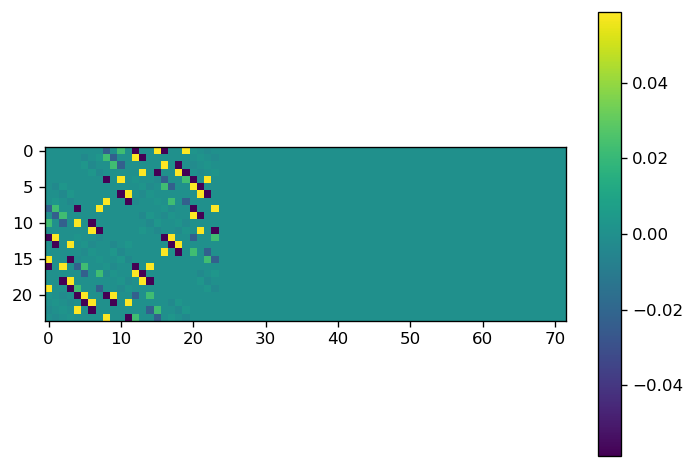

[-1.98314207e-01 -1.46004849e-01 -1.46004849e-01 -1.40718363e-01
 -1.22268506e-01 -1.22268506e-01 -2.94493933e-02 -2.94493933e-02
 -2.59483042e-02 -1.28465074e-16 -6.52366801e-17 -3.16114395e-17
 -2.88820179e-17  1.63607646e-17  3.30596158e-17  3.16475361e-02
  3.24701505e-02  3.24701505e-02  9.85859236e-02  9.85859236e-02
  1.66666667e-01  1.66666671e-01  1.66666674e-01  1.66666674e-01]


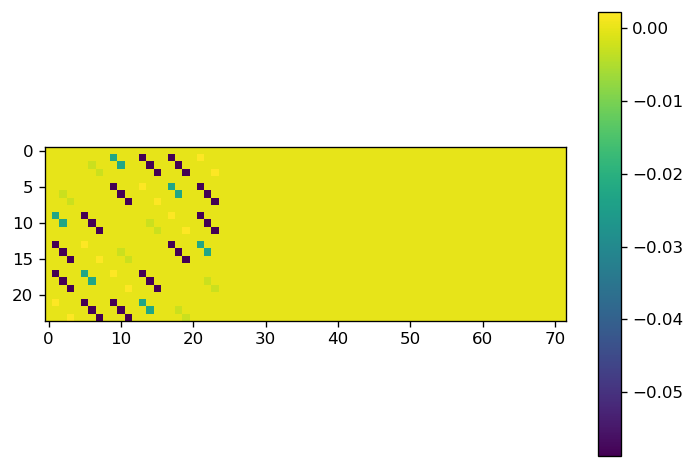

[-1.43044354e-01 -1.38058225e-01 -1.18105730e-01 -1.16939852e-01
 -9.69873569e-02 -9.20012282e-02 -5.92236185e-17 -5.54708666e-17
 -2.80720637e-17 -2.72316264e-17 -9.60861104e-18  0.00000000e+00
  3.48474406e-02  3.48474406e-02  3.72808440e-02  3.72808440e-02
  5.44334555e-02  5.44334555e-02  6.30893354e-02  6.30893354e-02
  8.02419469e-02  8.02419469e-02  8.26753503e-02  8.26753503e-02]


In [47]:

masked = np.real(np.round(Lambda*mat, 7))
print(masked.shape)
vals = list(set(np.real(masked.flatten())))
vals.sort()

print(vals)
val_mat_min = np.zeros(masked.shape)
val_mat_max =np.zeros(masked.shape)
for i in range(masked.shape[-1]):
    for j in range(masked.shape[0]):
        if masked[i,j] == vals[-1]:
            val_mat_max[i,j] = Lambda[i,j]
            print('big', to_str(perms[i]), to_str(perms[j]), dist(cycle_to_standard(perms[i]), cycle_to_standard(perms[j])))
        elif masked[i,j] == vals[0]:
            val_mat_min[i,j] = Lambda[i,j]
            print('small', to_str(perms[i]), to_str(perms[j]), dist(cycle_to_standard(perms[i]), cycle_to_standard(perms[j])))
val_mat = val_mat_min + val_mat_max
# print(mask.shape, val_mat.shape)         
mask_val = mat*val_mat
diff_val = np.kron(Lambda, np.ones((n*m, n*m))) * oracle_diffs
diff_val_phase = np.kron(Lambda, np.ones((n*m, n*m))) * phase_diffs
print('valmat', set(val_mat.flatten()))
visualize(masked)
print('min')
visualize(val_mat_min)
print('max')
visualize(val_mat_max)
visualize(val_mat)
visualize(mask_val, (perms, perms), to_string=True)
visualize(diff_val, complex=True)
# print(diff_val)
# print(phase_diffs)
diff_evals, diff_evects = np.linalg.eigh(diff_val)
phase_diff_evals, phase_diff_evects = np.linalg.eigh(diff_val_phase)
print(diff_evals)
visualize(diff_val_phase, complex=True)
print(phase_diff_evals)


# min_evals, min_evects = np.linalg.eigh(val_mat_min)
# print(min_evals)
# visualize(min_evects, (perms, perms), to_string=True)
# max_evals, max_evects = np.linalg.eigh(val_mat_max)

# print(max_evals)
# visualize(max_evects, (perms, perms), to_string=True)

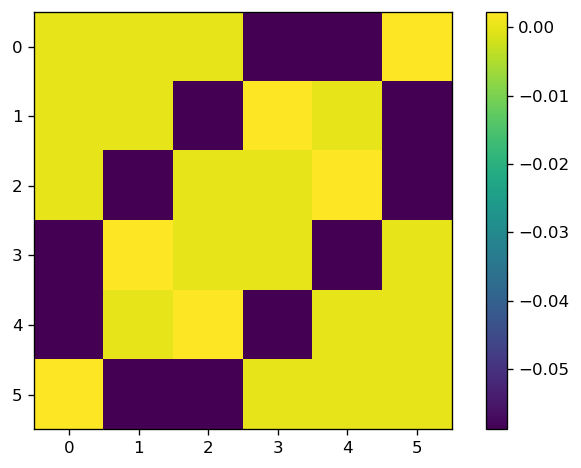

6
[{'0312, 0', '0231, 0', '0231, 3', '0231, 1', '0312, 2', '0123, 3', '0312, 1', '0312, 3', '0123, 2', '0123, 1', '0231, 2', '0123, 0'}, {'0132, 0', '0321, 0', '0213, 3', '0321, 1', '0213, 0', '0132, 3', '0213, 2', '0321, 3', '0213, 1', '0132, 2', '0321, 2', '0132, 1'}]


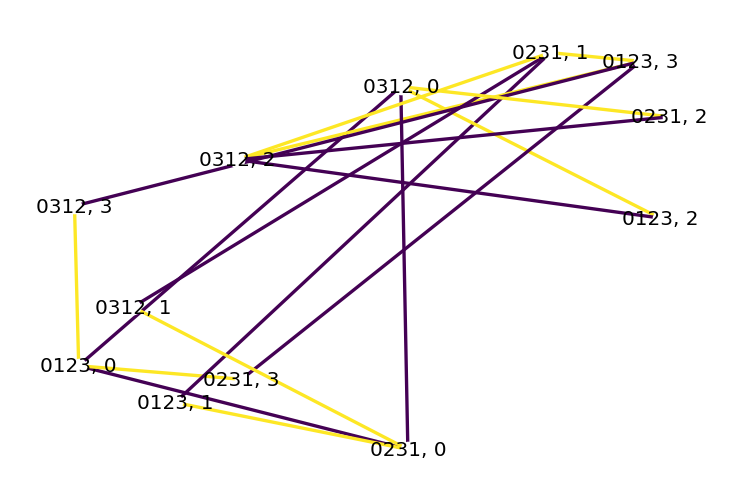

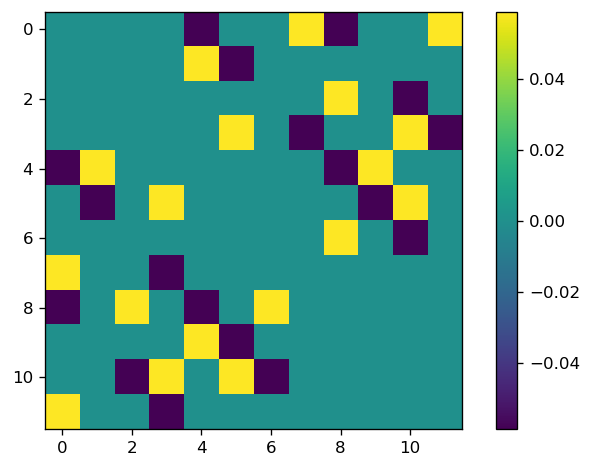

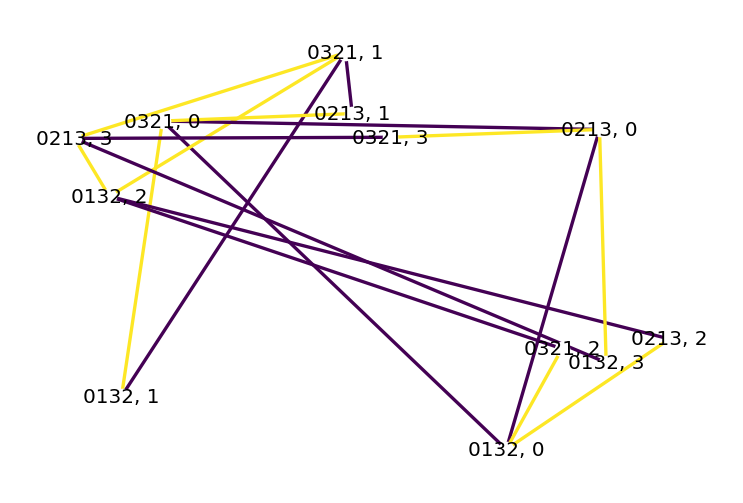

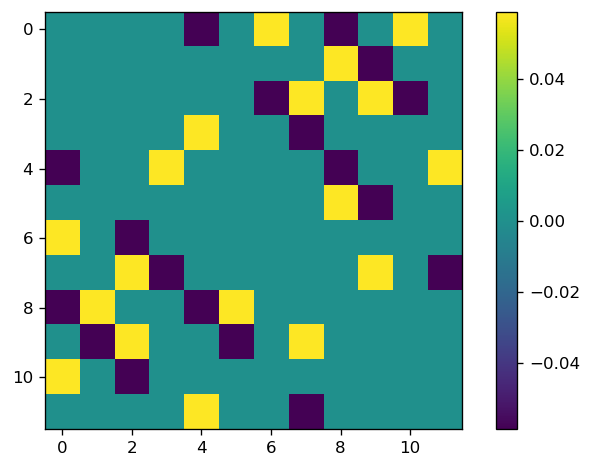

In [15]:
# %matplotlib notebook
# import ipympl
# %matplotlib widget
visualize(val_mat)
perm_block  = oracle_diffs
oracle_val_mat = oracle_diffs*np.kron(val_mat_max, np.ones((n*m, n*m)))
G = nx.from_numpy_array(oracle_val_mat)
# visualize(oracle_val_mat)
print(len(perms))
perms_index = list(product([to_str(perm) + ', 'for perm in perms], range(n)))
G = nx.relabel_nodes(G, {i:to_str(perms_index[i]) for i in range(len(perms_index))})

# largest_components=sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)[:phase_block.shape[0]]
# i=0
# pos = spectral_layout(G)
# nx.draw(G, pos, node_color='w', )
# edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())

# pos = nx.circular_layout(G)
# print('G')
# nx.draw(G, pos, node_color='w', edgelist=edges, edge_color=weights, width=2.0,node_size=70, edge_cmap=plt.cm.viridis, with_labels=True)

print(list(nx.connected_components(G)))
for c in list(nx.connected_components(G)):
    # print(c)
    try:
        plt.figure(i)
        c=nx.Graph(nx.induced_subgraph(G, c))
        edges,weights = zip(*nx.get_edge_attributes(c,'weight').items())

        pos = nx.spring_layout(c)
        nx.draw(c, pos, node_color='w', edgelist=edges, edge_color=weights, width=2.0,node_size=70, edge_cmap=plt.cm.viridis, with_labels=True)
        # c_mat =nx.to_numpy_array(c)
        # vals, vects = np.linalg.eigh(c_mat)
        visualize(nx.to_numpy_array(c))
    # print('norm', np.linalg.norm(c_mat@vects[:,0]))
    # print(vals)
    # visualize(vects, (c.nodes, c.nodes))
    
    # g = InteractiveGraph(c, node_size=2, edge_width=0.5)
    # plt.show()
    # nx.draw(c, pos, node_color='b', width=1, node_size=30)
    # plt.show()

    except:
        pass
    # nx.draw_spring()
# labels = list(product(perms, range(n)))
# evect = np.linalg.eigh(perm_block)[1][:, -1]
# evect = evect/np.max(np.abs(evect))
# print(evect)
# print(perm_block@evect)
# interactive graph jupyter
# visualize(perm_block, (labels, labels))
# visualize(phase_block, (labels, labels))
# perm_block = perm_block - phase_block
# perm_vals, perm_vects =np.linalg.eigh(perm_block)
# phase_vals, phase_vects =np.linalg.eigh(phase_block)
# Lambda_vals, Lambda_vects = np.linalg.eigh(Lambda)
# big_vals_neg, big_vects_neg = np.linalg.eigh(W*(-perm_block+phase_block))
# big_vals_pos, big_vects_pos = np.linalg.eigh(W*phase_block)
# print(Lambda_vals)
# visualize(np.outer(Lambda_vects[:,-1], Lambda_vects[:, -1]), (perms, perms))
# visualize(np.array([Lambda_vects[:, -1]]).T, ([1], perms))
# print(big_vals)
# visualize(big_vects)
# visualize(np.array([big_vects_neg[:, -1], big_vects_pos[:, -1]]).T, ([1,2], list(product(perms, range(n)))))
# visualize()
# print(big_vects_pos[:,-1]@big_vects_neg[:,-1])
# visualize((perm_block- phase_block )@(phase_block))

In [67]:
print(set(np.rounoracle_diffs_listnp.max(G), 7)))

SyntaxError: unmatched ')' (Temp/ipykernel_27384/716199844.py, line 1)

In [ ]:
print(G[0,1])

In [16]:
# print(oracle_diffs)
# print(oracle_diffs_list)
print(len(oracle_diffs_list), np.math.factorial(n-2))
fac = len(perm_types[0])
# print('fac', fac)
for j in range(n):
    curr_sum =  np.zeros((n, n))
    for i in list(range(0, j*fac)) + list(range((j+1)*fac, len(oracle_diffs_list))):
        curr_sum =G[j, i] * curr_sum + oracle_diffs_list[j][i]
    print(j, np.linalg.norm(curr_sum, 2))
    visualize(curr_sum)

NameError: name 'oracle_diffs_list' is not defined

In [ ]:
perm_mat = oracle_diffs * np.kron(mat, np.ones((n, n)))
cevals, cevects = np.linalg.eig(mat)
print((np.round(np.real(1/cevects[0,0]), 9)))
print(set(np.round(np.real(evects[:, 0]), 9)))
# visualize(perm_mat)
evals, evects = np.linalg.eig(perm_mat)
# visualize(np.real(evects))
# visualize(oracle_diffs)
# print(evals[0], evals[0])
visualize(np.real(cevects))


# print(evals[0])
# print(evects[0, :])

In [65]:
d = 4
b = 0
block = np.eye(d)
# outer_block = 
M = np.ones((d,d)) - np.eye(d)
mask = np.zeros((d,d))
mask[d//2,3] = 1
M = np.kron(mask, M)

# num_indices = d^2//2
# print(num_indices)
# zero_indices = np.random.randint(0, d, num_indices)
# print(zero_indices )
# zero_indices2 = np.random.randint(0, d, num_indices)

M2 = M
# M2[zero_indices, zero_indices2] = 0
# M2[zero_indices2, 
# zero_indices] = 0
# M2 = M2*(np.ones(M.shape)-np.eye(M.shape[0]))
# M[1,1] = 
# M[1,2] = 5
# M[2,1] = 5

# M = np.linalg.h/
print(np.min(val_mat_max), np.max(val_mat_max))
norm_mask =  np.kron(val_mat_max/np.abs(np.min(val_mat_max)), np.ones((n,n))) 
perm_diffs_norm = oracle_diffs * norm_mask
print(standard_perms)
phase_diffs = np.block(phase_oracle_diffs(standard_perms)) * norm_mask
visualize(perm_diffs_norm)
visualize(phase_diffs)
# visualize(M2)
evals, evects = np.linalg.eigh(M2)
print(np.max(evals))
print(evals)
# visualize(evects)
def min_norm_block(mat, block_size):
    not_block_size = mat.shape[0]//block_size
    new_vals = cp.Variable((not_block_size, not_block_size), symmetric=True)
    constraints = [ cp.sum(new_vals)>=1]
    new_vals_big = cp.kron(np.ones((block_size, block_size)), new_vals)
    mask = np.ones(mat.shape)
    for i in range(not_block_size):
        for j in range(not_block_size):
            if np.linalg.norm(mat[i*(block_size):(i+1)*(block_size),j*(block_size)*(j+1)block_size], 2)!=0:
                mask[i,j] = 0
    constraints += [
        cp.multiply(new_vals_big, mask) == np.zeros(mat.shape)
    ]
    opt_prob = cp.Problem(cp.Minimize(cp.norm(cp.multiply(mat, new_vals_big),2)/np.linalg.norm(mat, 2)), constraints)
    opt_prob.solve(verbose=True, solver='MOSEK')
    print('val', opt_prob.value)
    return new_vals.value
    
def min_norm_0(mat):
    new_vals = cp.Variable(mat.shape, symmetric=True)
    constraints = [cp.multiply(new_vals, np.eye(mat.shape[0]))==np.zeros(mat.shape)]
    constraints += [
        cp.multiply(new_vals, np.ones(mat.shape)-mat) == np.zeros(mat.shape)
    ]
    opt_prob = cp.Problem(cp.Minimize(cp.lambda_max(mat + new_vals,2)/np.linalg.norm(mat, 2)), constraints)
    opt_prob.solve(verbose=False, solver='MOSEK')
    print('val', opt_prob.value)
    return new_vals.value

def min_norm_block(mat1, mat2, block_size):
    var_size = mat1.shape[0] // block_size
    G = cp.Variable((var_size, var_size), symmetric=True)
    G_big = np.kron(G, np.ones((block_size block_size)))
    lmax1 = cp.variable()
    lmax2 = cp.variable()
    t = cp.variable()
    constraints = [lmax1 <= t <= lmax2]
    constraints += [
        lmax1 * np.eye(mat1.shape[0]) - cp.multiply(G_big, mat1) >> 0,
        lmax2 * np.eye(mat2.shape[0]) - cp.multiply(G_big, mat2) >> 0 
     ]
    opt_prob = cp.Problem(cp.Minimize(t)
new_vals = min_norm_block(perm_diffs_norm, n)
visualize(new_vals)
new_vals_phase = min_norm_block(phase_diffs, n)
visualize(new_vals_phase)
# new_vals = min_norm_0(M2)

# visualize(M2)
# # visualize(M2+new_vals)
# evals, evects = np.linalg.eigh(M2+new_vals)
# print(evals)
# # visualize(evects)
# visualize(M2+new_vals)
# visualize(new_vals)


SyntaxError: invalid syntax. Perhaps you forgot a comma? (3797718013.py, line 46)

2.0


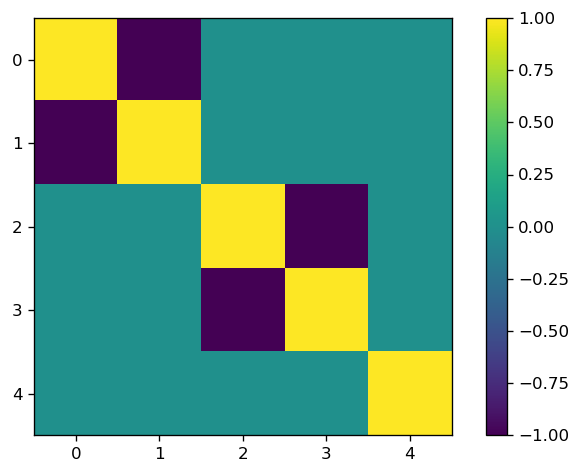

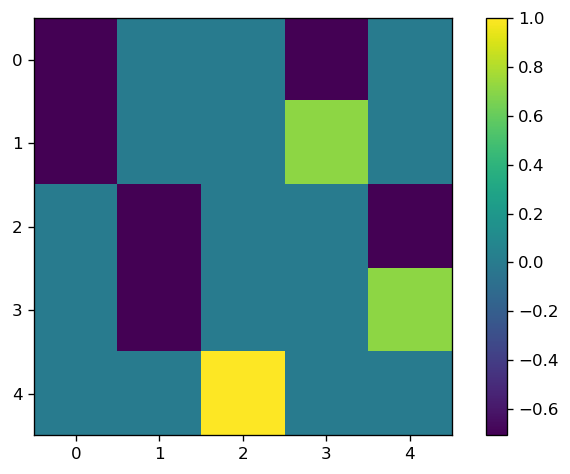

In [15]:
def min_pm(size, num_change):
    min_val = size
    min_mat = np.eye((size))
    possible_pairs = [(i,j) for i in range(size) for j in range(i)]
    for assignment in itertools.combinations(possible_pairs, num_change):
        mat = np.eye((size))
        for i,j in assignment:
            mat[i,j] = -1
            mat[j,i] = -1
        max_eval = np.linalg.eigvalsh(mat)[-1]
        if max_eval < min_val:
            min_val = max_eval
            min_mat = mat
    return min_val, min_mat

val, mat = min_pm(5, 2)
print(val)
visualize(mat)
visualize(np.linalg.eigh(mat)[1])

In [ ]:
print(M)


In [ ]:
M.eigenvals()

In [ ]:
perm_mat

In [ ]:
print(perm_types)

In [ ]:
global_perm_assignment = {}
count = 0
for t, ps in perm_types.items():
    for p in ps:
        global_perm_assignment[p] = count
        count += 1
# print(global_perm_assignment)

In [ ]:
n =7
k = 2

# perms, mat = index_or(n)
# perms = list(itertools.permutations)
# perms = [perm for perm in perms.instances if perm.index(0)!=0]


perms = list(itertools.permutations(range(n)))
print('completed perms')
# # perms = perms[:3] + perms[-2:]
keys, perm_types = search_perm_sorter(perms)
print('perm types')
# # print(len(perms), len(keys))
oracles = get_oracles(perms, permutation_oracle)
print("oracles")
# # print(len(oracles))
oracle_diffs_list = get_oracle_diffs(oracles, keys=keys, prod=True, mat=True)
print("diff list")
# print(keys)
# # print('blah', len(oracle_diffs_list), len(oracle_diffs_list[0]), oracle_diffs_list[0][0].shape)
# # print(oracle_diffs_list)
oracle_diffs = np.block(oracle_diffs_list)
print("block")
# visualize(oracle_diffs)
mat = search_mask(perms, assignment=keys)
# print(mat)
diff_mat = oracle_diffs*np.kron(mat, np.ones((n,n)))

print(np.linalg.norm(diff_mat, 2), np.linalg.norm(oracle_diffs, 2), np.linalg.norm(np.ones(mat.shape), 2))

# visualize(diff_mat)
# visualize(oracle_diffs)

block_size = len(perm_types[1])
for i in range(n):
    for j in range(n):
        if i != j:
            starti = i * block_size * n
            endi = starti + block_size * n
            startj = j * block_size * n
            endj = startj + block_size *n
            curr_block = oracle_diffs[starti: endi, startj:endj]
            print(i,j, np.linalg.norm(curr_block, 2))
            # visualize(curr_block)
            

In [ ]:
def visualize(mat, labels=None, to_string=False, save=None, complex=False):
    if complex:
        fig, ax = plt.subplots(nrows=1,ncols=2)
        mats = [np.real(mat), np.imag(mat)]
    else:
        fig, ax = plt.subplots()
        mats = [mat]
    heatmap = ax.imshow(mat)
    plt.tight_layout()
    figh, figw = fig.get_size_inches()
    font_sizey = figh * 72  / 3 
    font_sizey = font_sizey / np.max(mat.shape)
    font_sizex = figw * 72  / 3 / np.mat(mat.shape)
    
    # fig.set_size_inches(mat., mat.shape[1]/5)
    
    for i, ax in enumerate(axes.flat):
        if labels is not None:
            fig.subplots_adjust(bottom=0.25, left=0.25)np.zeros((mat.shape[]))
            xlabels, ylabels = labels
            if to_string:
                xlabels = to_str_list(xlabels)
                ylabels = to_str_list(ylabels)
            # print(xlabels)
            # print(ylabels)
            # print(mat.shape)
            ax.set_xticks(np.arange(mat.shape[1]), minor=False)
            ax.set_yticks(np.arange(mat.shape[0]), minor=False)
            # print(len(xlabels))
            ax.set_xticklabels(xlabels, rotation=90, fontsize=font_sizey)
            ax.set_yticklabels(ylabels, fontsize=font_sizey)
            ax.imshow(i + np.random.random((10, 10)), cmap=cmap, norm=normalizer)
             
    cmap = cm.get_cmap('viridis')
    normalizer = Normalize(0, 4)
    im = cm.ScalarMappable(norm=normalizer)
    
        
        ax.set_title(str(i))
    fig.colorbar(im, ax=axes.ravel().tolist())

    if save is not None:
        plt.savefig(save)
    else:
        plt.show()


In [ ]:
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig, axes = plt.subplots(nrows=2, ncols=2)
cmap = cm.get_cmap('viridis')
normalizer = Normalize(-4, 4)
# im = cm.ScalarMappable(norm=normalizer)
for i, ax in enumerate(axes.flat):
    ax.imshow(i + np.random.random((10, 10)), cmap=cmap)
    ax.set_title(str(i))
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

In [13]:
A = np.random.rand(5,5)
print(A)
A[2,:] = 0
print(A)

[[0.45403464 0.85298168 0.66035565 0.10667666 0.044153  ]
 [0.39999231 0.05256254 0.59111124 0.60814969 0.03829421]
 [0.08694845 0.03192456 0.77628546 0.18653575 0.25153755]
 [0.71878452 0.87403705 0.8070858  0.68545112 0.5870912 ]
 [0.31372513 0.21083346 0.4218709  0.01169032 0.0402523 ]]
[[0.45403464 0.85298168 0.66035565 0.10667666 0.044153  ]
 [0.39999231 0.05256254 0.59111124 0.60814969 0.03829421]
 [0.         0.         0.         0.         0.        ]
 [0.71878452 0.87403705 0.8070858  0.68545112 0.5870912 ]
 [0.31372513 0.21083346 0.4218709  0.01169032 0.0402523 ]]


In [37]:
P = np.array([
    [1,0,-1],
    [-1,1,0],
    [0,-1,1]
])
block = np.block([
    [np.zeros(P.shape), P],
    [P.T, np.zeros(P.shape)]]
)

block2 = np.block([
    [np.zeros(P.shape), np.eye(P.shape[0])],
    [np.eye(P.shape[0]), np.zeros(P.shape)]
])
print(np.linalg.eigvalsh(block))
print(np.linalg.eigvalsh(block2))

[-1.73205081e+00 -1.73205081e+00 -8.10840888e-17  4.63896193e-17
  1.73205081e+00  1.73205081e+00]
[-1. -1. -1.  1.  1.  1.]
